In [2]:
import pandas as pd
import numpy as np
import math
import datetime
from datetime import datetime
import matplotlib.pyplot as plt

# Order TFs based on the expected demand pattern, 
we can consider various factors such as the type of passengers, their booking behavior, and the proximity to the departure date. Here's a hypothetical ordering:
- TF 1: Initial surge of bookings from passengers who plan well in advance.
- TF 10: Last-minute bookings from travelers who need flexibility or discounted fares.
- TF 2: Bookings from early planners but with slightly lower demand compared to TF 1.
- TF 3: Continuation of bookings from early planners, gradually decreasing.
- TF 9: Last-minute bookings from travelers who missed out on earlier opportunities.
- TF 4: Moderate demand, representing a mix of early and mid-term planners.
- TF 5: Moderate demand, representing a mix of mid-term planners and those seeking specific dates.
- TF 8: Last-minute bookings from travelers with fixed schedules.
- TF 6: Moderate demand, representing travelers who plan closer to the departure date.
- TF 7: Moderate demand, with a mix of last-minute and near-term planners.

In [3]:
def generate_demand_rates(flight_details, num_tfs=10):
    # Constants
    NUM_WEEKS = 52
    DAYS_IN_WEEK = 7
    NUM_DAYS = NUM_WEEKS * DAYS_IN_WEEK
    
    # Initialize dictionary to store demand rates
    demand_rate_per_tf = {}

    # Iterate over each flight
    for flight, details in flight_details.items():
        # Extract flight details
        departure_city = details["departure_city"]
        arrival_city = details["arrival_city"]
        duration = details["duration"]
        carrier_type = details["carrier_type"]
        classes = details["classes"]
        
        # Initialize dictionary to store demand rates for this flight
        flight_demand = {}

        # Define the ordering of TFs for all classes
        tf_order = [1, 10, 2, 3, 4, 9, 5, 6, 8, 7]  # Adjusted TF order
        
        # Iterate over each class in the flight
        for class_name, class_details in classes.items():
            class_capacity = class_details["class_capacity"]
            
            # Initialize base demand rates based on TF order
            base_demand_rates = np.linspace(1, 10, num_tfs)
            
            # Seasonality factors for each week of the year (sinusoidal for simplicity)
            seasonality_factors = (np.sin(np.linspace(0, 2 * np.pi, NUM_WEEKS)) + 1) / 2 + 0.5

            # Initialize dictionary to store demand rates for this class
            class_demand = {}
            
            np.random.seed(42)  # For reproducibility
            for day in range(NUM_DAYS):
                week_of_year = day // DAYS_IN_WEEK
                seasonality_factor = seasonality_factors[week_of_year]
                day_demand = {}
                for tf, tf_num in zip(tf_order, range(num_tfs)):
                    # Adjust base demand rate with seasonality and some randomness
                    demand_rate = base_demand_rates[tf_num] * seasonality_factor * np.random.uniform(1.8, 2.2)
                    # Ensure demand does not exceed class capacity
                    demand_rate = min(demand_rate, class_capacity)
                    # Store demand rate for this TF
                    day_demand[f'TF{tf-1}'] = demand_rate

                # Store demand for this day
                class_demand[f'day{day + 1}'] = day_demand

            # Store demand for this class
            flight_demand[class_name] = class_demand

        # Store demand for this flight
        demand_rate_per_tf[flight] = flight_demand

    return demand_rate_per_tf

# Example usage
flight_details = {
    "FL100": {
        "departure_city": "AKL",
        "arrival_city": "SYD",
        "duration": 210,
        "carrier_type": "Narrow Body",
        "classes": {
            "Economy": {"class_capacity": 180},
            "Premium Economy": {"class_capacity": 30},
            "Business": {"class_capacity": 20}
        }
    }
}

flight_details = {
    "FL100": {"departure_city": "AKL", "arrival_city": "SYD", "duration": 180, "carrier_type": "Narrow Body",
              "classes": {"Economy": {"class_capacity": 180}, "Business": {"class_capacity": 30}, "First Class": {"class_capacity": 10}}},
    "FL101": {"departure_city": "AKL", "arrival_city": "LAX", "duration": 780, "carrier_type": "Wide Body",
              "classes": {"Economy": {"class_capacity": 250}, "Business": {"class_capacity": 50}, "First Class": {"class_capacity": 14}}},
    "FL102": {"departure_city": "AKL", "arrival_city": "NRT", "duration": 660, "carrier_type": "Wide Body",
              "classes": {"Economy": {"class_capacity": 225}, "Business": {"class_capacity": 45}, "First Class": {"class_capacity": 12}}},
    "FL103": {"departure_city": "AKL", "arrival_city": "FJI", "duration": 240, "carrier_type": "Narrow Body",
              "classes": {"Economy": {"class_capacity": 150}, "Business": {"class_capacity": 20}, "First Class": {"class_capacity": 8}}},
    "FL104": {"departure_city": "AKL", "arrival_city": "CHC", "duration": 85, "carrier_type": "Regional Jet",
              "classes": {"Economy": {"class_capacity": 90}, "Business": {"class_capacity": 20}}},
}

demand_rate_per_tf = generate_demand_rates(flight_details)

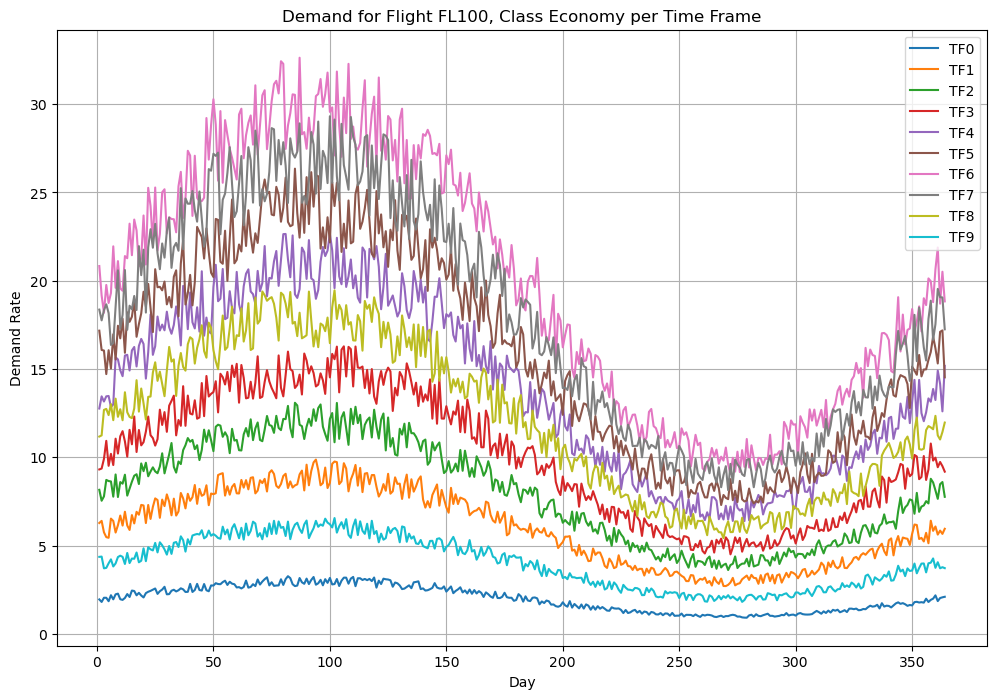

In [4]:
def plot_demand_per_tf(demand_rate_per_tf, flight_number, class_name):
    # Extract demand rates for the specified flight and class
    demand_data = demand_rate_per_tf[flight_number][class_name]

    # Get the number of time frames
    num_tfs = len(demand_data['day1'])

    # Plot demand for each time frame
    plt.figure(figsize=(12, 8))
    for tf in range(num_tfs):
        demand = [demand_data[f'day{i}'][f'TF{tf}'] for i in range(1, len(demand_data) + 1)]
        plt.plot(range(1, len(demand) + 1), demand, label=f'TF{tf}')
    plt.xlabel('Day')
    plt.ylabel('Demand Rate')
    plt.title(f'Demand for Flight {flight_number}, Class {class_name} per Time Frame')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_demand_per_tf(demand_rate_per_tf, 'FL100', 'Economy')

In [5]:
def estimate_bookings_today(flight_details, demand_rate_per_tf, flight_number, class_name, today_date_str, departure_date_str, num_tfs=10):
    # Get flight details
    flight_info = flight_details[flight_number]
    departure_date = datetime.datetime.strptime(departure_date_str, '%Y-%m-%d')
    print("departure_date: ", departure_date)
    today = datetime.datetime.strptime(today_date_str, '%Y-%m-%d')
    print("today: ", today)
    # Calculate the number of days until the departure date
    days_until_departure = (departure_date - today).days
    print("days until departure: ", days_until_departure)
    if days_until_departure < 0:
        print("The departure date has already passed.")
        return

    # Calculate the day of the year for the departure date
    day_of_year_departure = departure_date.timetuple().tm_yday
    print("departure day of year: ", day_of_year_departure)
    # Calculate the day of the year for today
    day_of_year_today = today.timetuple().tm_yday
    print("today day of year: ", day_of_year_today)
    # Calculate the number of TFs for today
    num_tfs_today = min(math.floor((365 - days_until_departure) / (365 / num_tfs)), num_tfs)
    print("number of tfs for today: ", num_tfs_today)
    # Calculate the total number of bookings
    total_bookings = 0
    for i in range(1, num_tfs_today + 1):  # Include num_tfs_today in the range
        print("tf: ", i-1)
        demand_rate = demand_rate_per_tf[flight_number][class_name][f'day{day_of_year_today}'][f'TF{i-1}']
        total_bookings += min(np.random.poisson(demand_rate), flight_info['classes'][class_name]['class_capacity'])

    return total_bookings

# Example usage
flight_number = 'FL103'
class_name = 'Economy'
today_date = '2024-02-27'
departure_date = '2024-05-01'
estimated_bookings = estimate_bookings_today(flight_details, demand_rate_per_tf, flight_number, class_name, today_date, departure_date, num_tfs=10)
print(f"Estimated bookings for flight {flight_number}, class {class_name} up to {today_date}: {estimated_bookings}")

departure_date:  2024-05-01 00:00:00
today:  2024-02-27 00:00:00
days until departure:  64
departure day of year:  122
today day of year:  58
number of tfs for today:  8
tf:  0
tf:  1
tf:  2
tf:  3
tf:  4
tf:  5
tf:  6
tf:  7
Estimated bookings for flight FL103, class Economy up to 2024-02-27: 132


### Load factor (65%, 70%, 80%, 90%, 95%, 100%)

### Bid Price
create a function that for a flight it gets , number of seats avialable, and days to departue and can calculate the bid price

How It Works:

It computes the difference in expected revenue between having 
n units and  n−1 units of inventory, capturing the marginal value of an additional seat.
This marginal value is used as the bid price, representing the minimum price at which selling an additional seat is profitable.

In the context of dynamic pricing and inventory management, In the context of dynamic pricing and inventory management, a zero bid price indicates that there is no expected increase in revenue from withholding a seat for future sales, suggesting that selling it at any positive price would be preferable to not selling it at all.a zero bid price indicates that there is no expected increase in revenue from withholding a seat for future sales, suggesting that selling it at any positive price would be preferable to not selling it at all.

This scenario underscores the principle of opportunity cost in revenue management. When the bid price is zero, the model suggests that the opportunity cost of keeping a seat unsold (in anticipation of possibly selling it at a higher price later) is outweighed by the benefit of selling it now, even at a lower price. This is because the marginal revenue gained from an additional sale at this point is effectively zero, making it more beneficial to secure any additional revenue that can be obtained before the flight departs.This scenario underscores the principle of opportunity cost in revenue management. When the bid price is zero, the model suggests that the opportunity cost of keeping a seat unsold (in anticipation of possibly selling it at a higher price later) is outweighed by the benefit of selling it now, even at a lower price. This is because the marginal revenue gained from an additional sale at this point is effectively zero, making it more beneficial to secure any additional revenue that can be obtained before the flight departs.

#### Arrival Rate Function (arrival_rate)
The arrival_rate function can be adjusted to account for fluctuations in booking rates depending on the day of the week and how close the departure date is. Booking rates might be higher on certain days due to patterns in travel planning behavior, and they often increase as the departure date approaches.

In [6]:
def arrival_rate(mean_arrival, departure_day_of_week, days_until_departure, tf_length = 36.5):

    departure_day_of_week_modifier = {
        'Monday': 1.0,
        'Tuesday': 0.9,
        'Wednesday': 0.95,
        'Thursday': 1.05,
        'Friday': 1.1,
        'Saturday': 0.85,
        'Sunday': 1.0
    }
    print("mean_arrival: ", mean_arrival)
    adjusted_mean_arrival = mean_arrival / tf_length * departure_day_of_week_modifier[departure_day_of_week]
    print("adjusted_mean_arrival: ", adjusted_mean_arrival)
    arrival_rate = 1 - math.exp(-1 * adjusted_mean_arrival)
    print("arrival_rate: ", arrival_rate)
    return arrival_rate

#### Willingness to Pay Function (WTP)
The WTP function could be adjusted to reflect how price sensitivity varies with the proximity to the departure date and potentially by the day of the week, as last-minute travelers might be willing to pay more.

In [7]:
def wtp_probability(price, base_price, days_to_departure, alpha=0.2, beta=0.05):
    '''
    Calculate the willingness to pay probability based on price and time
    '''
    if price <= base_price:
        return 1.0
    else:
        price_difference = price - base_price # Ensure positive difference
        price_factor = 1 / (1 + alpha * np.log(1 + price_difference))
        print("price factor: ", price_factor)
        # Time adjustment factor that increases as departure date approaches
        days_factor = 1 + beta * (10 - (days_to_departure) / 36.5)
        print("days factor: ", days_factor)
        # Combine factors and ensure the result is between 0 and 1
        wtp = min(1, price_factor * days_factor)

        return wtp
    
# Parameters for example
alpha = 0.2 
beta = 0.05
price = 1500
base_price = 1000
days_to_departure_2 = 300
days_to_departure_1 = 1

# Calculate WTP probability with the revised function
wtp_10_days = wtp_probability(price, base_price, days_to_departure_2)
wtp_1_day = wtp_probability(price, base_price, days_to_departure_1, alpha, beta)
print(f"WTP for ${price}, {days_to_departure_2} days to departure: {wtp_10_days:.2f}")
print(f"WTP for ${price}, {days_to_departure_1} day to departure: {wtp_1_day:.2f}")

price factor:  0.44576763728169094
days factor:  1.0890410958904109
price factor:  0.44576763728169094
days factor:  1.4986301369863013
WTP for $1500, 300 days to departure: 0.49
WTP for $1500, 1 day to departure: 0.67


In [8]:
def find_tf_from_days_to_departure(days_to_departure):
    NUMBER_OF_TFS = 10
    days_in_tf = 365 / NUMBER_OF_TFS
    tf  = int(10 - days_to_departure / days_in_tf)
    return tf, days_in_tf
find_tf_from_days_to_departure(33)

(9, 36.5)

In [9]:
def convert_date_to_dow(date_string):
    # Parse the date string to a datetime object
    date = datetime.strptime(date_string, "%Y-%m-%d")
    
    # Convert datetime object to day of the week
    # The strftime function with '%A' returns the full weekday name
    day_of_week = date.strftime('%A')
    return day_of_week

# Example usage:
# Assuming the date format is "Year-Month-Day"
date_string = "2024-03-02"  # Replace with your actual date string
day_of_week = convert_date_to_dow(date_string)
print(f"The day of week for {date_string} is {day_of_week}.")

The day of week for 2024-03-02 is Saturday.


In [10]:
def convert_date_to_doy(date_string):
    # Convert the date string to a datetime object
    date_object = datetime.strptime(date_string, "%Y-%m-%d")
    # Get the day of the year
    return date_object.timetuple().tm_yday

# Example usage:
date_string = "2024-11-18"  # Use the format "YYYY-MM-DD"
day_of_year = convert_date_to_doy(date_string)
print(f"The day of year for {date_string} is {day_of_year}.")

The day of year for 2024-11-18 is 323.


### Create competitor data for each flight
I think the best way to get price is use Amadeus API

### Create web session data

### Willingness to Pay 

In [44]:
class BidCalculator:
    def __init__(self, price_range, flight_number, flight_class, departure_date, demand_rate_per_tf, delta_t):
        self.price_min, self.price_max = price_range
        self.flight_number = flight_number
        self.flight_class = flight_class
        self.departure_day_of_year = convert_date_to_doy(departure_date)
        self.departure_day_of_week = convert_date_to_dow(departure_date)
        self.demand_rate_per_tf = demand_rate_per_tf
        self.delta_t = delta_t

    def calculate_bid_price(self, seats, time):
        memo = {}
        # Fill the memo table with calculated values
        self.V(seats, time, memo)
        # Calculate and return the optimal bid prices for all (seat, time) combinations
        return {(s, t): self.b_star(s, t, memo) for s in range(1, seats + 1) for t in range(1, time + 1)}

    def V(self, x, t, memo):
        if x == 0 or t <= 0:
            return 0
        if (x, t) in memo:
            return memo[(x, t)]

        price_step = int((self.price_max - self.price_min) / 10)  # Assuming a discrete set of prices to check
        D_lambda = self.arrival_rate(t)
        max_value = max(
            min(1, D_lambda * self.delta_t * self.wtp_probability(p, t)) * (p + self.V(x - 1, t - self.delta_t, memo))
            + (1 - min(1, D_lambda * self.delta_t * self.wtp_probability(p, t))) * self.V(x, t - self.delta_t, memo)
            for p in range(self.price_min, self.price_max + price_step, price_step)
        )

        memo[(x, t)] = max_value
        return max_value

    def b_star(self, x, t, memo):
        # Check if the value for the current and next state is already computed
        current_value = memo.get((x, t - self.delta_t))
        if current_value is None:
            current_value = self.V(x, t - self.delta_t, memo)

        next_value = memo.get((x - 1, t - self.delta_t))
        if next_value is None:
            next_value = self.V(x - 1, t - self.delta_t, memo)

        # The bid price is the difference in the expected value when selling one more seat
        bid_price = current_value - next_value
        return bid_price
    
###############################################################################
    def arrival_rate(self, days_to_departure):
        
        departure_day_of_week_modifier = {
            'Monday': 1.0,
            'Tuesday': 0.9,
            'Wednesday': 0.95,
            'Thursday': 1.05,
            'Friday': 1.1,
            'Saturday': 0.85,
            'Sunday': 1.0
        }
        tf, days_in_tf = find_tf_from_days_to_departure(days_to_departure)
        mean_arrival = self.demand_rate_per_tf[self.flight_number][self.flight_class][f'day{self.departure_day_of_year}'][f'TF{tf}']
#         print("TF: ", tf)
#         print("mean arrival: ", mean_arrival)
        adjusted_mean_arrival = mean_arrival / days_in_tf * departure_day_of_week_modifier[self.departure_day_of_week] 
#         print("Adjusted mean arrival: ", adjusted_mean_arrival)
        arrival_rate = 1 - math.exp(-1 * adjusted_mean_arrival)
#         print("Arrival rate: ", arrival_rate)
        return arrival_rate
    
###############################################################################
    def wtp_probability(self, price, days_to_departure, alpha=0.2, beta=0.05):
        '''
        Calculate the willingness to pay probability based on price and time
        '''
        if price <= base_price:
            return 1.0
        else:
            price_difference = price - self.price_min # Ensure positive difference
            price_factor = 1 / (1 + alpha * np.log(1 + price_difference))
            # Time adjustment factor that increases as departure date approaches
            days_factor = 1 + beta * (10 - (days_to_departure) / 36.5)
            # Combine factors and ensure the result is between 0 and 1
            wtp = min(1, price_factor * days_factor)
        return wtp
    
###############################################################################
# Example usage
if __name__ == '__main__':
    bid_calculator = BidCalculator((100, 400), 'FL100', 'Economy', '2024-03-23', demand_rate_per_tf, 0.5)
    optimal_bid_prices = bid_calculator.calculate_bid_price(seats=30, time=30)
    print(optimal_bid_prices) 

{(1, 1): 200.0, (1, 2): 350.0, (1, 3): 387.5, (1, 4): 396.875, (1, 5): 399.21875, (1, 6): 399.8046875, (1, 7): 399.951171875, (1, 8): 399.98779296875, (1, 9): 399.9969482421875, (1, 10): 399.9992370605469, (1, 11): 399.9998092651367, (1, 12): 399.9999523162842, (1, 13): 399.99998807907104, (1, 14): 399.99999701976776, (1, 15): 399.99999925494194, (1, 16): 399.9999998137355, (1, 17): 399.99999995343387, (1, 18): 399.99999998835847, (1, 19): 399.9999999970896, (1, 20): 399.9999999992724, (1, 21): 399.9999999998181, (1, 22): 399.9999999999545, (1, 23): 399.99999999998863, (1, 24): 399.99999999999716, (1, 25): 399.9999999999993, (1, 26): 399.99999999999983, (1, 27): 399.99999999999994, (1, 28): 400.0, (1, 29): 400.0, (1, 30): 400.0, (2, 1): 0.0, (2, 2): 200.0, (2, 3): 325.0, (2, 4): 375.0, (2, 5): 392.1875, (2, 6): 397.65625, (2, 7): 399.31640625, (2, 8): 399.8046875, (2, 9): 399.945068359375, (2, 10): 399.9847412109375, (2, 11): 399.9958038330078, (2, 12): 399.9988555908203, (2, 13): 399.

In [ ]:
# Understand the bid price, for example WTP = 1 and arrival_rate = 1 what should we expect?